# Example - Olist

<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data</a></span></li></ul></li><li><span><a href="#Checking-the-support-in-the-different-environments" data-toc-modified-id="Checking-the-support-in-the-different-environments-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Checking the support in the different environments</a></span><ul class="toc-item"><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Benchmark</a></span></li></ul></li><li><span><a href="#Challenger-model" data-toc-modified-id="Challenger-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Challenger model</a></span></li><li><span><a href="#Feature-Importance-migration" data-toc-modified-id="Feature-Importance-migration-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Importance migration</a></span></li><li><span><a href="#Reverse-Learning-Curve" data-toc-modified-id="Reverse-Learning-Curve-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Reverse Learning Curve</a></span></li><li><span><a href="#Performance-comparison" data-toc-modified-id="Performance-comparison-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Performance comparison</a></span></li><li><span><a href="#TRF-as-feature-selection" data-toc-modified-id="TRF-as-feature-selection-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>TRF as feature selection</a></span></li><li><span><a href="#Feature-Impact" data-toc-modified-id="Feature-Impact-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Feature Impact</a></span></li><li><span><a href="#Minimum-samples-by-period-effect" data-toc-modified-id="Minimum-samples-by-period-effect-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Minimum samples by period effect</a></span></li><li><span><a href="#Domain-classifier" data-toc-modified-id="Domain-classifier-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Domain classifier</a></span></li><li><span><a href="#Other-optimization-design-for-the-RF" data-toc-modified-id="Other-optimization-design-for-the-RF-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Other optimization design for the RF</a></span></li></ul></div>

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from time_robust_forest.models import TimeForestClassifier
from time_robust_forest.functions import check_categoricals_match, check_numerical_match
from time_robust_forest.hyper_opt import env_wise_hyper_opt
from aux_functions import *

np.random.seed(42)

In [7]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [8]:
set_style()

In [9]:
DATASETS_PATH = "~/Documents/datasets/olist/"
PREFIX = "olist"
N_BOOTSTRAP = 10

In [10]:
orders = pd.read_csv(DATASETS_PATH + "olist_orders_dataset.csv", engine="python")
customers = pd.read_csv(DATASETS_PATH + "olist_customers_dataset.csv", engine="python")
reviews = pd.read_csv(DATASETS_PATH + "olist_order_reviews_dataset.csv", engine="python")
payments = pd.read_csv(DATASETS_PATH + "olist_order_payments_dataset.csv", engine="python")
products = pd.read_csv(DATASETS_PATH + "olist_products_dataset.csv", engine="python")
category = pd.read_csv(DATASETS_PATH + "product_category_name_translation.csv", engine="python")
items = pd.read_csv(DATASETS_PATH + "olist_order_items_dataset.csv", engine="python")

In [11]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders.order_purchase_timestamp)
orders['order_approved_at'] = pd.to_datetime(orders.order_approved_at).dt.date  
orders['order_estimated_delivery_date'] = pd.to_datetime(orders.order_estimated_delivery_date).dt.date  
orders['order_delivered_customer_date'] = pd.to_datetime(orders.order_delivered_customer_date).dt.date  
items['shipping_limit_date'] = pd.to_datetime(items.shipping_limit_date).dt.date  

In [12]:
data = orders.merge(reviews, on="order_id", how="left")
data = data.merge(items, on="order_id", how="left")
data = data.merge(products, on="product_id", how="left")

In [13]:
data["Year"] = data["order_purchase_timestamp"].apply(lambda x: int(x.year))
data["Year-month"] = data["order_purchase_timestamp"].apply(lambda x: str(x.year) + "-" + str(x.month).zfill(2))
data["Year-quadri"] = data["order_purchase_timestamp"].apply(lambda x: str(x.year) + "-" + str(int(x.month / 3)).zfill(2))
data["Year-tri"] = data["order_purchase_timestamp"].apply(lambda x: str(x.year) + "-" + str(int(x.month / 4)).zfill(2))

In [14]:
data["difference_estimated_delivered"] = (data['order_estimated_delivery_date'] - data['order_delivered_customer_date']).dt.days
data["difference_limit_delivered"] = (data['shipping_limit_date'] - data['order_delivered_customer_date']).dt.days

In [15]:
data.shape

(114100, 34)

In [16]:
data["target"] = (data["review_score"] == 5).astype(int)
data["target"].mean()

0.5582646801051709

## Modeling

### Data

In [17]:
TIME_COLUMN = "Year-month"
ALTERNATIVE_TIME_COLUMN = "Year-quadri"
ALTERNATIVE_TIME_COLUMN_2 = "Year-tri"
TIME_COLUMN = ALTERNATIVE_TIME_COLUMN_2
TARGET = "target"

In [18]:
columns_to_label_encode = ["seller_id",
                           "product_category_name"]

In [19]:
encoder_mappings = {}
le = LabelEncoder()
for column in columns_to_label_encode:
    print(column)
    data[column].fillna("None", inplace=True)
    data[column] = le.fit_transform(data[[column]])
    encoder_mappings[column] = {i: le.__dict__["classes_"][i] for i in range(len(le.__dict__["classes_"]))}

seller_id
product_category_name


/home/jovyan/.conda/envs/ml/lib/python3.9/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [20]:
numerical_features = ["price",
                      "freight_value",
                      "product_name_lenght",
                      "product_description_lenght", 
                      "product_photos_qty", 
                      "product_weight_g",
                      "product_length_cm",
                      "product_height_cm", 
                      "product_width_cm",
                      "difference_estimated_delivered",
                      "difference_limit_delivered"]

In [21]:
features = columns_to_label_encode + numerical_features
features = list(set(features))

In [22]:
data["Year"].value_counts()

2018    61912
2017    51796
2016      392
Name: Year, dtype: int64

In [23]:
data = data[~data["Year"].isin([2016])]

In [24]:
training_start_year = 2017
training_end_year = 2017
holdout_end_year = 2018

In [25]:
in_time = data[data["Year"] <= training_end_year]
in_time = in_time[in_time["Year"] >= training_start_year]
out_of_time = data[data["Year"] > training_end_year]

In [26]:
out_of_time = out_of_time[~out_of_time[TIME_COLUMN].isin(["2018-10", "2018-09"])]

In [27]:
train, test = train_test_split(in_time, 
                               test_size=0.2,
                               random_state=42)

In [28]:
train.shape

(41436, 35)

In [29]:
test.shape

(10360, 35)

In [30]:
out_of_time.shape

(61912, 35)

In [31]:
median_input = train.median()
train.fillna(median_input, inplace=True)
test.fillna(median_input, inplace=True)
out_of_time.fillna(median_input, inplace=True)

/tmp/ipykernel_96/1872798990.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  median_input = train.median()
/home/jovyan/.conda/envs/ml/lib/python3.9/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


## Checking the support in the different environments

In [32]:
check_categoricals_match(train, columns_to_label_encode, TIME_COLUMN)

Year-tri
2017-00    0.357558
2017-01    0.523837
2017-02    0.739535
2017-03    0.472093
Name: seller_id, dtype: float64
Year-tri
2017-00    0.821918
2017-01    0.931507
2017-02    0.958904
2017-03    0.863014
Name: product_category_name, dtype: float64


0.7085457151959222

In [33]:
check_numerical_match(train, numerical_features, TIME_COLUMN, verbose=True, n_q=10)

/home/jovyan/.conda/envs/ml/lib/python3.9/site-packages/time_robust_forest/functions.py:240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numerical_feature + "_quant"] = pd.cut(


Year-tri
2017-00    0.777778
2017-01    0.888889
2017-02    0.555556
2017-03    0.555556
Name: price_quant, dtype: float64
Year-tri
2017-00    0.7
2017-01    1.0
2017-02    0.9
2017-03    0.6
Name: freight_value_quant, dtype: float64
Year-tri
2017-00    0.9
2017-01    1.0
2017-02    1.0
2017-03    1.0
Name: product_name_lenght_quant, dtype: float64
Year-tri
2017-00    1.0
2017-01    1.0
2017-02    1.0
2017-03    1.0
Name: product_description_lenght_quant, dtype: float64
Year-tri
2017-00    0.9
2017-01    1.0
2017-02    1.0
2017-03    1.0
Name: product_photos_qty_quant, dtype: float64
Year-tri
2017-00    0.888889
2017-01    0.888889
2017-02    1.000000
2017-03    1.000000
Name: product_weight_g_quant, dtype: float64
Year-tri
2017-00    1.0
2017-01    1.0
2017-02    1.0
2017-03    1.0
Name: product_length_cm_quant, dtype: float64
Year-tri
2017-00    1.0
2017-01    1.0
2017-02    1.0
2017-03    1.0
Name: product_height_cm_quant, dtype: float64
Year-tri
2017-00    1.0
2017-01    1.0
2017-0

0.9023989898989899

### Benchmark

In [34]:
from pycaret.classification import *

In [35]:
TARGET

'target'

In [36]:
clf1 = setup(train[features + [TARGET]], 
             target=TARGET,
             session_id=2, 
             log_experiment=False, 
             experiment_name="{}".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6221,0.6536,0.7359,0.6384,0.6837,0.2203,0.2238
1,0.6244,0.6633,0.7459,0.6382,0.6879,0.2234,0.2277
2,0.6178,0.6550,0.7285,0.6358,0.6790,0.2122,0.2152
3,0.6239,0.6654,0.7307,0.6414,0.6831,0.2252,0.2281
4,0.6282,0.6635,0.7493,0.6411,0.6910,0.2313,0.2357
Mean,0.6233,0.6602,0.7381,0.6390,0.6849,0.2225,0.2261
Std,0.0034,0.0048,0.0082,0.0021,0.0041,0.0063,0.0067


In [37]:
tuned_rf

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=11, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=250, n_jobs=-1, oob_score=False,
                       random_state=2, verbose=0, warm_start=False)

In [38]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_sklearn"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_sklearn"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_sklearn"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [39]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_sklearn"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_sklearn"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_sklearn"]))

0.7203083665768092
0.6496785374572761
0.6372817498802512


In [40]:
params_grid = {"n_estimators": [140], 
              "max_depth": [5, 12],
              "min_impurity_decrease": [1e-3, 0],
              "min_sample_periods": [5, 10],
              "period_criterion": ["max", "avg"]}

params_grid_benchmark = params_grid.copy()
params_grid_benchmark.pop("period_criterion")
# params_grid = {"n_estimators": [5], 
#               "max_depth": [5],
#               "min_impurity_decrease": [0.001],
#               "min_sample_periods": [5]}

['max', 'avg']

In [41]:
params_grid

{'n_estimators': [140],
 'max_depth': [5, 12],
 'min_impurity_decrease': [0.001, 0],
 'min_sample_periods': [5, 10],
 'period_criterion': ['max', 'avg']}

In [42]:
params_grid_benchmark

{'n_estimators': [140],
 'max_depth': [5, 12],
 'min_impurity_decrease': [0.001, 0],
 'min_sample_periods': [5, 10]}

In [43]:
DUMMY_TIME_COLUMN = "dummy_time_column"
train[DUMMY_TIME_COLUMN] = 1

In [44]:
# model = TimeForestClassifier(time_column=DUMMY_TIME_COLUMN,
#                                         multi=True)

# benchmark_opt_param = env_wise_hyper_opt(train[features + [DUMMY_TIME_COLUMN]], train[TARGET], 
#                                          model, 
#                                          DUMMY_TIME_COLUMN, 
#                                          params_grid_benchmark, 
#                                          cv=5,
#                                          scorer=make_scorer(roc_auc_score,
#                                                              needs_proba=True))


In [45]:
benchmark_opt_param = {'max_depth': 12,
 'min_impurity_decrease': 0,
 'min_sample_periods': 5,
 'n_estimators': 240}

In [46]:
bootstrap_dict = {}

In [48]:
bootstrap_dict["benchmark"] = {"train": [], "test": [], "holdout": []}


for n in range(N_BOOTSTRAP):
    resampled_train = train.sample(frac=1, replace=True)
    benchmark_model = TimeForestClassifier(time_column=DUMMY_TIME_COLUMN,
                                       multi=True, 
                                       **benchmark_opt_param)
    benchmark_model.fit(resampled_train[features + [DUMMY_TIME_COLUMN]], resampled_train[TARGET].values)
    train["benchmark_prediction"] = benchmark_model.predict_proba(train[features])[:, 1]
    test["benchmark_prediction"] = benchmark_model.predict_proba(test[features])[:, 1]
    out_of_time["benchmark_prediction"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]
    train_perf = roc_auc_score(train[TARGET], train["benchmark_prediction"])
    test_perf = roc_auc_score(test[TARGET], test["benchmark_prediction"])
    holdout_perf = roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction"])
    print(train_perf)
    print(test_perf)
    print(holdout_perf)
    
    print("******")
    
    bootstrap_dict["benchmark"]["train"].append(train_perf)
    bootstrap_dict["benchmark"]["test"].append(test_perf)
    bootstrap_dict["benchmark"]["holdout"].append(holdout_perf)

0.7721168466730101
0.6576869981851222
0.6309601565669282
******
0.7733025356060709
0.6558836445845487
0.6328179593007042
******
0.7705018462809174
0.6511114428126439
0.630845698755178
******
0.7683565007434092
0.6544104710654666
0.6324651429940411
******
0.7729966263841059
0.6530302632508098
0.6368762598165245
******
0.7695502885124174
0.656342795955726
0.6334579366580637
******
0.7768467544704294
0.6583829489921
0.6301663929584376
******
0.7789992207065016
0.6560144642489623
0.6325762655355227
******
0.7809035810383624
0.6592221865624213
0.6315163338024572
******


In [49]:
# results = reverse_learning_curve(train, 
#                                  out_of_time, 
#                                  benchmark_model, 
#                                  features, 
#                                  TARGET,
#                                  TIME_COLUMN, 
#                                  roc_auc_score, 
#                                  n_rounds=5,
#                                  dummy_time_column=DUMMY_TIME_COLUMN)

In [50]:
# benchmark_importances = results["feature_importance"][-1].copy(deep=True)
# benchmark_importances.rename("RF", inplace=True)

In [51]:
# importance_by_reverse_segment_benchmark = plot_feature_migration_from_learning_curve_results(results, 
#                                                                                              features, 
#                                                                                              save_as="../images/{}_benchmark_importance_migration_learning_curve.eps".format(PREFIX))

In [52]:
# fig, ax = plt.subplots()

# blues = plt.get_cmap("Blues")
# gradient = np.linspace(.2, 0.8, len(results["holdout_performance"]))

# for i, r in enumerate(results["holdout_performance_by_period"]):
#     r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

# ax.xaxis.set_tick_params(labelsize=12)
# ax.yaxis.set_tick_params(labelsize=12)
# plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
# plt.ylabel("AUC", fontsize=15)
# plt.xlabel("Year", fontsize=15)

# plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
# plt.show()

In [53]:
# results

## Challenger model

In [54]:
train.reset_index(drop=True, inplace=True)

In [55]:
train[features + [TIME_COLUMN]]

,product_weight_g,product_height_cm,product_name_lenght,product_photos_qty,product_description_lenght,product_width_cm,seller_id,difference_limit_delivered,product_length_cm,difference_estimated_delivered,price,product_category_name,freight_value,Year-tri
0,350.0,5.0,51.0,2.0,2025.0,20.0,510,5.0,20.0,24.0,267.99,45,15.63,2017-02
1,756.0,21.0,44.0,3.0,368.0,24.0,1330,-6.0,32.0,19.0,49.90,13,15.70,2017-00
2,1000.0,30.0,53.0,3.0,220.0,20.0,1113,1.0,20.0,9.0,129.90,54,9.72,2017-02
3,350.0,4.0,56.0,1.0,351.0,11.0,1798,-10.0,19.0,8.0,14.50,71,15.10,2017-01
4,3800.0,15.0,59.0,2.0,302.0,35.0,881,-6.0,45.0,15.0,199.90,15,26.24,2017-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41431,100.0,2.0,35.0,7.0,920.0,25.0,604,7.0,20.0,27.0,89.00,34,17.90,2017-03
41432,200.0,8.0,30.0,2.0,227.0,11.0,468,3.0,16.0,11.0,40.00,34,7.78,2017-01
41433,1000.0,10.0,28.0,2.0,855.0,25.0,961,-4.0,30.0,15.0,213.00,10,18.74,2017-01
41434,250.0,8.0,54.0,2.0,1536.0,21.0,2482,-1.0,20.0,24.0,56.99,63,14.15,2017-02


In [56]:
train["Year"].value_counts()

2017    41436
Name: Year, dtype: int64

In [57]:
# model = TimeForestClassifier(time_column=TIME_COLUMN,
#                                         multi=True)

# challenger_opt_param = env_wise_hyper_opt(train[features + [TIME_COLUMN]], 
#                                           train[TARGET], 
#                                           model, 
#                                           TIME_COLUMN,
#                                           params_grid,
#                                           cv=5,
#                                           scorer=make_scorer(roc_auc_score,
#                                                              needs_proba=True))



In [58]:
challenger_opt_param = {'max_depth': 12,
 'min_impurity_decrease': 0,
 'min_sample_periods': 5,
 'n_estimators': 240,
 'period_criterion': 'avg'}

In [ ]:
bootstrap_dict["challenger"] = {"train": [], "test": [], "holdout": []}

for n in range(N_BOOTSTRAP):
    resampled_train = train.sample(frac=1, replace=True)
    challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        multi=True,
                                        **challenger_opt_param)

    challenger_model.fit(resampled_train[features + [TIME_COLUMN]], 
                         resampled_train[TARGET].values)

    train["challenger_prediction"] = challenger_model.predict_proba(train[features])[:, 1]
    test["challenger_prediction"] = challenger_model.predict_proba(test[features])[:, 1]
    out_of_time["challenger_prediction"] = challenger_model.predict_proba(out_of_time[features])[:, 1]
    
    train_perf = roc_auc_score(train[TARGET], train["challenger_prediction"])
    test_perf = roc_auc_score(test[TARGET], test["challenger_prediction"])
    holdout_perf = roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction"])
    print(train_perf)
    print(test_perf)
    print(holdout_perf)
    
    print("******")
    
    bootstrap_dict["challenger"]["train"].append(train_perf)
    bootstrap_dict["challenger"]["test"].append(test_perf)
    bootstrap_dict["challenger"]["holdout"].append(holdout_perf)    

0.6878524113067556
0.63496975606282
0.6329084548531483
******
0.69024360323932
0.6361048090334676
0.6333671392472435
******
0.6944560692814639
0.6384764812799626
0.6321684628129736
******


In [60]:
challenger_opt_param

{'max_depth': 12,
 'min_impurity_decrease': 0,
 'min_sample_periods': 5,
 'n_estimators': 240,
 'period_criterion': 'avg'}

### Ensemble

In [61]:
bootstrap_dict["ensemble"] = {"train": [], "test": [], "holdout": []}


for n in range(N_BOOTSTRAP):
    resampled_train = train.sample(frac=1, replace=True)
    model = TimeForestClassifier(time_column=DUMMY_TIME_COLUMN,
                                       multi=True, 
                                       **benchmark_opt_param)
    model.fit(resampled_train[features + [DUMMY_TIME_COLUMN]], resampled_train[TARGET].values)
    train["ensemble_prediction"] = model.predict_proba(train[features])[:, 1]
    test["ensemble_prediction"] = model.predict_proba(test[features])[:, 1]
    out_of_time["ensemble_prediction"] = model.predict_proba(out_of_time[features])[:, 1]
    train_perf = roc_auc_score(train[TARGET], train["ensemble_prediction"])
    test_perf = roc_auc_score(test[TARGET], test["ensemble_prediction"])
    holdout_perf = roc_auc_score(out_of_time[TARGET], out_of_time["ensemble_prediction"])
    print(train_perf)
    print(test_perf)
    print(holdout_perf)
    
    print("******")
    
    bootstrap_dict["ensemble"]["train"].append(train_perf)
    bootstrap_dict["ensemble"]["test"].append(test_perf)
    bootstrap_dict["ensemble"]["holdout"].append(holdout_perf)

0.7776136696344126
0.65273452329435
0.6308173701409396
******
0.7786408826128407
0.6613613973954363
0.6329747222990849
******
0.7802148437112384
0.6595020267240281
0.6339192927635761
******
0.7701573873549793
0.6568823704885323
0.6307789515132961
******
0.7760378761507838
0.6582487154927299
0.6315386840321193
******
0.7839104237311676
0.6569333894032149
0.6308910039904068
******
0.7750079057452564
0.6610938357230933
0.6315523783404511
******
0.777542096879668
0.6586048294033114
0.6349354868066643
******
0.7783610680668389
0.6584583174146774
0.6336524171253335
******
0.7764833074082877
0.6537423590452065
0.633198391412177
******


### Few engineered 

In [62]:
TIME_COLUMN

'Year-tri'

In [63]:
time_columns = [DUMMY_TIME_COLUMN, "Year-tri", "Year-quadri", "Year-month"]

In [65]:
bootstrap_dict["engineered"] = {"train": [], "test": [], "holdout": []}


for n in range(N_BOOTSTRAP):
    resampled_train = train.sample(frac=1, replace=True)
    model = TimeForestClassifier(time_column=TIME_COLUMN,
                                       multi=True, 
                                       random_segments=time_columns,
                                       **challenger_opt_param)
    model.fit(resampled_train[features + time_columns], resampled_train[TARGET].values)
    train["eng_prediction"] = model.predict_proba(train[features])[:, 1]
    test["eng_prediction"] = model.predict_proba(test[features])[:, 1]
    out_of_time["eng_prediction"] = model.predict_proba(out_of_time[features])[:, 1]
    train_perf = roc_auc_score(train[TARGET], train["eng_prediction"])
    test_perf = roc_auc_score(test[TARGET], test["eng_prediction"])
    holdout_perf = roc_auc_score(out_of_time[TARGET], out_of_time["eng_prediction"])
    print(train_perf)
    print(test_perf)
    print(holdout_perf)
    
    print("******")
    
    bootstrap_dict["engineered"]["train"].append(train_perf)
    bootstrap_dict["engineered"]["test"].append(test_perf)
    bootstrap_dict["engineered"]["holdout"].append(holdout_perf)

0.7086721988433753
0.6405684265306505
0.6314604105664531
******
0.7112068961550335
0.641037159272866
0.6296265986890924
******
0.7078495392877352
0.643468319008052
0.6302341670483745
******
0.709447899545305
0.6426088624815238
0.6326940617949979
******
0.7067295708037229
0.6432431945105836
0.6320477914848595
******
0.7081649455275527
0.639548123680864
0.6330571963623646
******
0.7110635099458744
0.64059113513445
0.6336017674081186
******
0.7051850611977613
0.6403247617030035
0.632959183477202
******
0.7083351426121827
0.6411722603767003
0.6321830695809232
******


### Few segments

In [66]:
bootstrap_dict["few"] = {"train": [], "test": [], "holdout": []}

for n in range(N_BOOTSTRAP):
    resampled_train = train.sample(frac=1, replace=True)
    model = TimeForestClassifier(time_column="order_purchase_timestamp",
                                       multi=True, 
                                       random_segments=3,
                                       **challenger_opt_param)
    model.fit(resampled_train[features + ["order_purchase_timestamp"]], resampled_train[TARGET].values)
    train["few_prediction"] = model.predict_proba(train[features])[:, 1]
    test["few_prediction"] = model.predict_proba(test[features])[:, 1]
    out_of_time["few_prediction"] = model.predict_proba(out_of_time[features])[:, 1]
    train_perf = roc_auc_score(train[TARGET], train["few_prediction"])
    test_perf = roc_auc_score(test[TARGET], test["few_prediction"])
    holdout_perf = roc_auc_score(out_of_time[TARGET], out_of_time["few_prediction"])
    print(train_perf)
    print(test_perf)
    print(holdout_perf)
    
    print("******")
    
    bootstrap_dict["few"]["train"].append(train_perf)
    bootstrap_dict["few"]["test"].append(test_perf)
    bootstrap_dict["few"]["holdout"].append(holdout_perf)

0.7522369488704086
0.6521808784804519
0.6336425897816733
******
0.7442258137355564
0.6525767135867162
0.6363297780602071
******
0.746661385259684
0.6517728026068572
0.6343771552555664
******
0.7416766331472003
0.6490210064392848
0.6331286367076316
******
0.7459074348406585
0.6480897084909355
0.6337782184571141
******
0.7455344058078395
0.6529598364014845
0.6326583556561309
******
0.7414744123873886
0.652920247232568
0.6329251650973611
******
0.7484410973797168
0.6522006447734601
0.6336055665870494
******
0.742987669972992
0.651878593768578
0.63320357755091
******
0.7470400235387286
0.6525519868594891
0.6331086467986407
******


### Many segments

In [67]:
bootstrap_dict["many"] = {"train": [], "test": [], "holdout": []}

for n in range(N_BOOTSTRAP):
    resampled_train = train.sample(frac=1, replace=True)
    model = TimeForestClassifier(time_column="order_purchase_timestamp",
                                       multi=True, 
                                       random_segments=20,
                                       **challenger_opt_param)
    model.fit(resampled_train[features + ["order_purchase_timestamp"]], resampled_train[TARGET].values)
    train["many_prediction"] = model.predict_proba(train[features])[:, 1]
    test["many_prediction"] = model.predict_proba(test[features])[:, 1]
    out_of_time["many_prediction"] = model.predict_proba(out_of_time[features])[:, 1]
    train_perf = roc_auc_score(train[TARGET], train["many_prediction"])
    test_perf = roc_auc_score(test[TARGET], test["many_prediction"])
    holdout_perf = roc_auc_score(out_of_time[TARGET], out_of_time["many_prediction"])
    print(train_perf)
    print(test_perf)
    print(holdout_perf)
    
    print("******")
    
    bootstrap_dict["many"]["train"].append(train_perf)
    bootstrap_dict["many"]["test"].append(test_perf)
    bootstrap_dict["many"]["holdout"].append(holdout_perf)

0.6827574376239254
0.6392050049762774
0.6336127825909678
******
0.6849516687924027
0.6374696262993697
0.6312983592211525
******
0.6839202541888568
0.6380281938255533
0.632998088255704
******
0.6836855023967163
0.6370526480495347
0.6334608821603238
******
0.6811542680925617
0.6341623180822049
0.6338361620259342
******
0.681890508207454
0.6338935115860654
0.6331668969920217
******
0.6847837477355323
0.6381243847552691
0.6323135804329478
******
0.6783654285065428
0.6338374945152309
0.6330172679132642
******
0.6787839049407343
0.6379582385003933
0.6360132366571405
******
0.6821488426677298
0.6362667304318225
0.6324360306071768
******


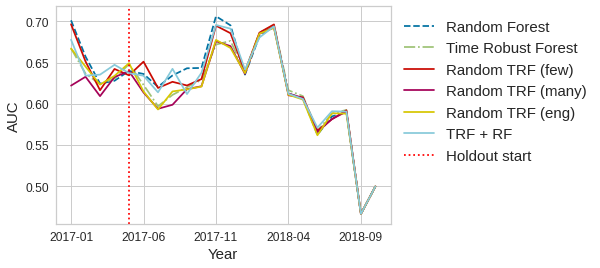

In [68]:
time_column = "Year-month"
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="Random Forest", 
                                                                                                                              linestyle="dashed")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                                       linestyle="-.")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[TARGET], x["few_prediction"])).plot(label="Random TRF (few)")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[TARGET], x["many_prediction"])).plot(label="Random TRF (many)")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[TARGET], x["eng_prediction"])).plot(label="Random TRF (eng)")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[TARGET], x["ensemble_prediction"])).plot(label="TRF + RF")


# pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["challenger_prediction"])).plot(label="Time Robust Forest",
#                                                                                                                         color="green", linestyle="dashed")
# pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Random Forest", 
#                                                                                                                        linestyle="-.")
# pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_lgbm"])).plot(label="LGBM", color="orange")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.vlines(4, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
#plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))

#plt.legend(bbox_to_anchor=(1.05, 1.0))
#plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")

plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
#plt.savefig("images/ge_sklearn.eps", format="eps", bbox_inches="tight")
plt.savefig("olist_overtime_all.eps", format="eps")
plt.show()

In [102]:
xp_df = pd.DataFrame.from_dict(bootstrap_dict)

In [105]:
xp_df = pd.melt(xp_df)
xp_df

,variable,value
0,benchmark,"[0.7713785393727186, 0.7721168466730101, 0.773..."
1,benchmark,"[0.6533698360936735, 0.6576869981851222, 0.655..."
2,benchmark,"[0.6336123970595682, 0.6309601565669282, 0.632..."
3,challenger,"[0.6878524113067556, 0.69024360323932, 0.69445..."
4,challenger,"[0.63496975606282, 0.6361048090334676, 0.63847..."
5,challenger,"[0.6329084548531483, 0.6333671392472435, 0.632..."
6,ensemble,"[0.7776136696344126, 0.7786408826128407, 0.780..."
7,ensemble,"[0.65273452329435, 0.6613613973954363, 0.65950..."
8,ensemble,"[0.6308173701409396, 0.6329747222990849, 0.633..."
9,engineered,"[0.7086721988433753, 0.7112068961550335, 0.707..."


In [106]:
xp_df["set"] = 6 * ["train", "test", "holdout"]
xp_df

,variable,value,set
0,benchmark,"[0.7713785393727186, 0.7721168466730101, 0.773...",train
1,benchmark,"[0.6533698360936735, 0.6576869981851222, 0.655...",test
2,benchmark,"[0.6336123970595682, 0.6309601565669282, 0.632...",holdout
3,challenger,"[0.6878524113067556, 0.69024360323932, 0.69445...",train
4,challenger,"[0.63496975606282, 0.6361048090334676, 0.63847...",test
5,challenger,"[0.6329084548531483, 0.6333671392472435, 0.632...",holdout
6,ensemble,"[0.7776136696344126, 0.7786408826128407, 0.780...",train
7,ensemble,"[0.65273452329435, 0.6613613973954363, 0.65950...",test
8,ensemble,"[0.6308173701409396, 0.6329747222990849, 0.633...",holdout
9,engineered,"[0.7086721988433753, 0.7112068961550335, 0.707...",train


In [107]:
xp_df = xp_df.explode(column="value")
xp_df

,variable,value,set
0,benchmark,0.771379,train
0,benchmark,0.772117,train
0,benchmark,0.773303,train
0,benchmark,0.770502,train
0,benchmark,0.768357,train
...,...,...,...
17,many,0.633167,holdout
17,many,0.632314,holdout
17,many,0.633017,holdout
17,many,0.636013,holdout


In [108]:
xp_df["value"] = xp_df["value"].astype(float)

In [109]:
1

1

In [123]:
xp_df.groupby(["variable", "set"]).mean()

value
variable   set              
benchmark  holdout  0.632529
           test     0.655546
           train    0.773495
challenger holdout  0.632854
           test     0.637022
           train    0.691028
engineered holdout  0.631991
           test     0.641514
           train    0.708898
ensemble   holdout  0.632426
           test     0.657756
           train    0.777397
few        holdout  0.633676
           test     0.651615
           train    0.745619
many       holdout  0.633215
           test     0.636600
           train    0.682244

In [124]:
xp_df.groupby(["variable", "set"]).std()

value
variable   set              
benchmark  holdout  0.001913
           test     0.002563
           train    0.004137
challenger holdout  0.001107
           test     0.001273
           train    0.002959
engineered holdout  0.001255
           test     0.001355
           train    0.002174
ensemble   holdout  0.001496
           test     0.002817
           train    0.003555
few        holdout  0.001054
           test     0.001674
           train    0.003275
many       holdout  0.001230
           test     0.001971
           train    0.002292

In [110]:
xp_df.to_csv("olist_experiments_results.csv")

(0.62, 0.635)

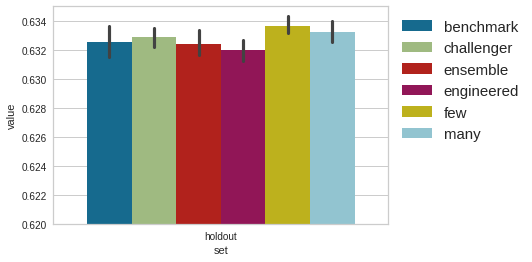

In [114]:
sns.barplot(data=xp_df[xp_df["set"] == "holdout"], x="set", y="value", hue="variable")
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylim([0.62, 0.635])

(0.62, 0.662)

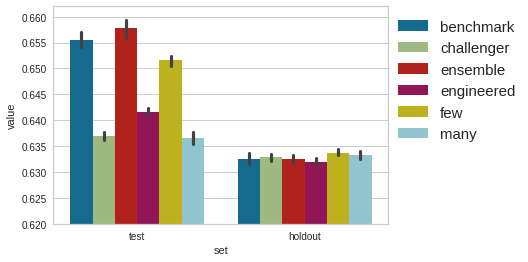

In [122]:
sns.barplot(data=xp_df[xp_df["set"] != "train"], x="set", y="value", hue="variable")
plt.legend(fontsize=15, bbox_to_anchor=(1.42, 1.0))
plt.ylim([0.62, 0.662])

### 